# Anomaly Detection (이상치 탐색)
<img src ='https://images.unsplash.com/photo-1536303100418-985cb308bb38?ixid=MnwxMjA3fDB8MHxzZWFyY2h8Mnx8b3V0bGllcnxlbnwwfHwwfHw%3D&ixlib=rb-1.2.1&auto=format&fit=crop&w=800&q=60'>

#### Points anomaly 
<img src = 'https://miro.medium.com/max/594/1*Lr3HSdp93oIDojSCWILMSg.png'>

#### Collective anomaly 
<img src = 'https://miro.medium.com/max/653/1*KEGMetf3Yf_QvJKS8n3oXg.png'>

#### Contextural anomaly 
<img src = 'https://miro.medium.com/max/653/1*zCIYjTebkPnmB0YYQMrNtg.png'>

In [1]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = 'all'
import warnings
warnings.filterwarnings('ignore')

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()
get_ipython().run_line_magic('matplotlib', 'inline')

### Algorithm selection for Anomaly Detection
- https://medium.com/analytics-vidhya/algorithm-selection-for-anomaly-detection-ef193fd0d6d1
<img src= 'https://miro.medium.com/max/1072/1*OIXCo35Vvzr9qoUbV2fHMA.png'>

### <font color='brown'> Unsupervised learning anomaly detection methods
<img src='https://miro.medium.com/max/1540/1*7yJ2KiW3RFHP2nJppTP4mw.png'>

## Understanding 자료 구성(Data format)
- 국건영 자료의 열량섭취량 자료는 다수의 개인(가구, m=4070)로 부터 단일변수(섭취량, p=1)을 24시간(t=24)에 받은 경우
             * 자료의 차원은 (4070 x 1 x 24)로 tabular data (4070 x 24)로 squeeze하여 시간을 특성변수로 간주
- HACCP 출연 과제에 응용가능(multivariate timeseries): 복수의 기계(m)에서 온도, 습도, 압력, 열 등의 특성변수(p)를 시간 시계열(t)로 받는 경우
             * 자료의 차원은 (m x p x t)
- 축산물 자료는 업체유형별로 m개 업체에서 유통재고, 종업원수, 매출의 특성변수(p=3)를 3년동안 매월(t=36) 관찰한 자료라면
             * 자료의 차원은 (m x 3 x 36)

# Multivariates anomaly detection
- 인스턴스가 시간이라고 가정하여 예제를 보기 바람
## 1. 데이터 생성

In [2]:
from pyod.utils.data import generate_data
import numpy as np
X_train, y_train, X_test, y_test = \
        generate_data(n_train=200,
                      n_test=100,
                      n_features=5,
                      contamination=0.1,
                      random_state=3)

df = pd.DataFrame(X_train, columns = ['col1', 'col2', 'col3', 'col4', 'col5'])
df.shape
df.head()

(200, 5)

,col1,col2,col3,col4,col5
0,8.068431,6.678508,7.803291,7.748423,7.941324
1,7.555364,7.968926,7.661582,7.068276,8.627328
2,8.624985,9.212340,8.035481,7.713024,7.613259
3,6.903319,8.696644,7.219180,7.159627,7.854164
4,9.053899,8.167867,7.273985,7.494382,8.443391


## 2. 데이터 시각화

<AxesSubplot:xlabel='col1', ylabel='Density'>

Text(0.5, 1.0, 'Distribution of Sales')

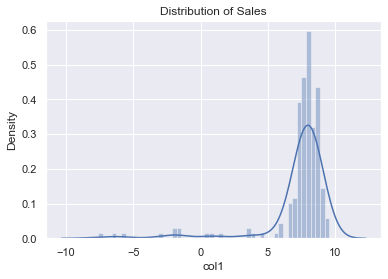

In [3]:
sns.distplot(df['col1'])
plt.title("Distribution of Sales")

In [4]:
print("Skewness: %f" % df['col1'].skew())
print("Kurtosis: %f" % df['col1'].kurt())

Skewness: -3.698873
Kurtosis: 14.592770


## 3. 이상치 탐지

### 3.1 Interquartile Range(IQR) - Box plot으로 outlier 탐색
- 단일 변수의 백분위수 (range)를 확인하여 이상치(outlier)를 그려보고 확인한다

<AxesSubplot:>

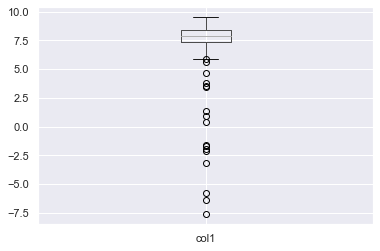

In [5]:
df.boxplot('col1')

- 하위 25% 기준치(l_fence), 상위 75%(u_fence) 설정
- 하위/상위 기준치 이하 이상의 데이터를 이상치로 가정

In [6]:
q1, q3 = df[ 'col1'].quantile(0.25), df['col1'].quantile(0.75)
iqr = q3 - q1
l_fence, u_fence = q1 - 1.5*iqr , q3 + 1.5*iqr  
print('Lower fence: ', l_fence, 'Upper fence: ', u_fence) #filtering = col.drop(outliers.index, axis = 0)

Lower fence:  5.88558530113195 Upper fence:  9.899245168954874


In [7]:
df['col1'][(df['col1'] < l_fence)]
df['col1'][(df['col1'] > u_fence)]

69     5.883924
181   -5.764589
182    3.536537
183   -1.933557
184    5.622612
185    3.481426
186    0.442411
187    0.951362
189   -2.114482
190    3.756458
191    1.390964
192   -7.630914
193    4.676552
195   -1.692050
197   -3.121663
198   -1.573072
199   -6.357678
Name: col1, dtype: float64

Series([], Name: col1, dtype: float64)

In [8]:
outliers = df['col1'][(df['col1'] < l_fence) | (df['col1'] > u_fence)]
print(f'컬럼1(col1)의 총 이상치 관측 수: {outliers.count()}')
outliers

컬럼1(col1)의 총 이상치 관측 수: 17


69     5.883924
181   -5.764589
182    3.536537
183   -1.933557
184    5.622612
185    3.481426
186    0.442411
187    0.951362
189   -2.114482
190    3.756458
191    1.390964
192   -7.630914
193    4.676552
195   -1.692050
197   -3.121663
198   -1.573072
199   -6.357678
Name: col1, dtype: float64

- 다변량 확인

<AxesSubplot:>

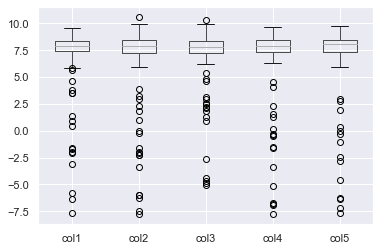

In [9]:
df.boxplot()

In [10]:
def Outliers(col):
    q1, q3 =col.quantile(0.15), col.quantile(0.95)
    iqr = q3 - q1
    l_fence, u_fence = q1 - 1.5*iqr , q3 + 1.5*iqr  
    outliers = col[(col < l_fence) | (col > u_fence)] 
    print(col.name,'의 총 이상치 관측 수:', outliers.count())
    print('Lower fence: ', l_fence, 'Upper fence: ', u_fence) #filtering = col.drop(outliers.index, axis = 0)
    return col

In [11]:
for col in df.columns:
    Outliers(df[col])
    print('*'*100)

col1 의 총 이상치 관측 수: 14
Lower fence:  3.9429084985745035 Upper fence:  12.034512430159118


0      8.068431
1      7.555364
2      8.624985
3      6.903319
4      9.053899
         ...   
195   -1.692050
196    6.666888
197   -3.121663
198   -1.573072
199   -6.357678
Name: col1, Length: 200, dtype: float64

****************************************************************************************************
col2 의 총 이상치 관측 수: 17
Lower fence:  3.0936946311161613 Upper fence:  12.797619689342408


0      6.678508
1      7.968926
2      9.212340
3      8.696644
4      8.167867
         ...   
195   -1.631723
196   -2.032396
197   -0.066943
198   -7.794527
199   -2.220367
Name: col2, Length: 200, dtype: float64

****************************************************************************************************
col3 의 총 이상치 관측 수: 14
Lower fence:  3.6319548114280598 Upper fence:  12.46274683882545


0      7.803291
1      7.661582
2      8.035481
3      7.219180
4      7.273985
         ...   
195    2.180102
196   -4.383138
197   -4.824039
198    1.872346
199    4.609412
Name: col3, Length: 200, dtype: float64

****************************************************************************************************
col4 의 총 이상치 관측 수: 15
Lower fence:  3.5413376093634716 Upper fence:  12.575863239712016


0      7.748423
1      7.068276
2      7.713024
3      7.159627
4      7.494382
         ...   
195   -1.641629
196   -1.493904
197   -0.274892
198    4.550900
199   -0.487505
Name: col4, Length: 200, dtype: float64

****************************************************************************************************
col5 의 총 이상치 관측 수: 14
Lower fence:  3.8636014958005944 Upper fence:  12.428308451588805


0      7.941324
1      8.627328
2      7.613259
3      7.854164
4      8.443391
         ...   
195    7.042153
196    7.884712
197    7.240568
198   -2.461419
199   -7.677689
Name: col5, Length: 200, dtype: float64

****************************************************************************************************


### 3.2 확률밀도함수로 이상치 확인
#### 단일변수의 확률밀도 함수를 확인하여 이상치를 p-value로 확인한다

In [12]:
import scipy as sp
sp.stats.norm(loc=0, scale=1) # 평균0, 표준편차 1
rv = sp.stats.norm(loc=0, scale=1)

가우시안 분포를 가정하여 pdf(probability density distribution)이 임계치를 넘으면 이상치라고 판단

z = 1.96의 pdf: 0.9415590556665485, z = 2.58의 pdf: 0.9856948910058503


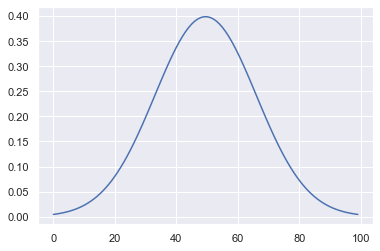

In [13]:
print(f'z = 1.96의 pdf: {1- rv.pdf(1.96)}, z = 2.58의 pdf: {1- rv.pdf(2.58)}')
plt.plot(rv.pdf(np.linspace(-3,3,100)))

Text(0.5, 0, 'instances')

Text(0, 0.5, 'pdf(probability density function)')

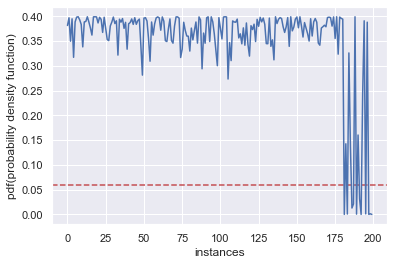

In [14]:
z = (df['col1'] - df['col1'].mean())/df['col1'].std()
plt.axhline(y= rv.pdf(1.96), color='r', linestyle='--')
plt.plot(rv.pdf(z))
plt.xlabel('instances'); plt.ylabel('pdf(probability density function)')

In [15]:
for col in df.columns:
    df[col] = (df[col] -df[col].mean())/df[col].std()
    df[col + '_pdf'] = rv.pdf(df[col])

In [16]:
df

,col1,col2,col3,col4,col5,col1_pdf,col2_pdf,col3_pdf,col4_pdf,col5_pdf
0,0.300548,-0.124778,0.191554,0.192675,0.213087,3.813250e-01,0.395849,3.916898e-01,0.391605,3.899871e-01
1,0.104091,0.285491,0.131715,-0.035583,0.452032,3.967869e-01,0.383011,3.954966e-01,0.398690,3.601966e-01
2,0.513657,0.680815,0.289600,0.180795,0.098817,3.496369e-01,0.316417,3.825590e-01,0.392475,3.969992e-01
3,-0.145582,0.516857,-0.055095,-0.004925,0.182728,3.947370e-01,0.349061,3.983373e-01,0.398937,3.923374e-01
4,0.677891,0.348741,-0.031953,0.107419,0.387964,3.170465e-01,0.375405,3.987387e-01,0.396647,3.700206e-01
...,...,...,...,...,...,...,...,...,...,...
195,-3.436812,-2.766888,-2.182916,-2.958632,-0.100108,1.086520e-03,0.008680,3.682787e-02,0.005013,3.969483e-01
196,-0.236113,-2.894276,-4.954336,-2.909056,0.193368,3.879755e-01,0.006052,1.866095e-06,0.005798,3.915531e-01
197,-3.984221,-2.269391,-5.140513,-2.499955,-0.030997,1.425317e-04,0.030379,7.291586e-07,0.017530,3.987507e-01
198,-3.391254,-4.726257,-2.312871,-0.880416,-3.410348,1.269363e-03,0.000006,2.749850e-02,0.270765,1.189556e-03


In [17]:
data = df[['col1_pdf', 'col2_pdf', 'col3_pdf', 'col4_pdf', 'col5_pdf']]
data

,col1_pdf,col2_pdf,col3_pdf,col4_pdf,col5_pdf
0,3.813250e-01,0.395849,3.916898e-01,0.391605,3.899871e-01
1,3.967869e-01,0.383011,3.954966e-01,0.398690,3.601966e-01
2,3.496369e-01,0.316417,3.825590e-01,0.392475,3.969992e-01
3,3.947370e-01,0.349061,3.983373e-01,0.398937,3.923374e-01
4,3.170465e-01,0.375405,3.987387e-01,0.396647,3.700206e-01
...,...,...,...,...,...
195,1.086520e-03,0.008680,3.682787e-02,0.005013,3.969483e-01
196,3.879755e-01,0.006052,1.866095e-06,0.005798,3.915531e-01
197,1.425317e-04,0.030379,7.291586e-07,0.017530,3.987507e-01
198,1.269363e-03,0.000006,2.749850e-02,0.270765,1.189556e-03


In [18]:
data[data < 0.05].fillna('Normal')

,col1_pdf,col2_pdf,col3_pdf,col4_pdf,col5_pdf
0,Normal,Normal,Normal,Normal,Normal
1,Normal,Normal,Normal,Normal,Normal
2,Normal,Normal,Normal,Normal,Normal
3,Normal,Normal,Normal,Normal,Normal
4,Normal,Normal,Normal,Normal,Normal
...,...,...,...,...,...
195,0.001087,0.00868,0.036828,0.005013,Normal
196,Normal,0.006052,0.000002,0.005798,Normal
197,0.000143,0.030379,0.000001,0.01753,Normal
198,0.001269,0.000006,0.027499,Normal,0.00119


#### 다중변수의 확률밀도 함수를 확인하여 이상치를 p-value로 확인한다
- 편의상 2개의 변수만 고려

In [19]:
df = pd.DataFrame(X_train, columns = ['col1', 'col2', 'col3', 'col4', 'col5'])
df

,col1,col2,col3,col4,col5
0,0.300548,-0.124778,0.191554,0.192675,0.213087
1,0.104091,0.285491,0.131715,-0.035583,0.452032
2,0.513657,0.680815,0.289600,0.180795,0.098817
3,-0.145582,0.516857,-0.055095,-0.004925,0.182728
4,0.677891,0.348741,-0.031953,0.107419,0.387964
...,...,...,...,...,...
195,-3.436812,-2.766888,-2.182916,-2.958632,-0.100108
196,-0.236113,-2.894276,-4.954336,-2.909056,0.193368
197,-3.984221,-2.269391,-5.140513,-2.499955,-0.030997
198,-3.391254,-4.726257,-2.312871,-0.880416,-3.410348


In [20]:
df.mean(); df.std()

col1    3.996803e-16
col2   -1.207923e-15
col3   -1.036948e-15
col4    5.839773e-16
col5   -3.046452e-15
dtype: float64

col1    1.0
col2    1.0
col3    1.0
col4    1.0
col5    1.0
dtype: float64

In [21]:
data =  df[['col1', 'col2']]
data.head()

,col1,col2
0,0.300548,-0.124778
1,0.104091,0.285491
2,0.513657,0.680815
3,-0.145582,0.516857
4,0.677891,0.348741


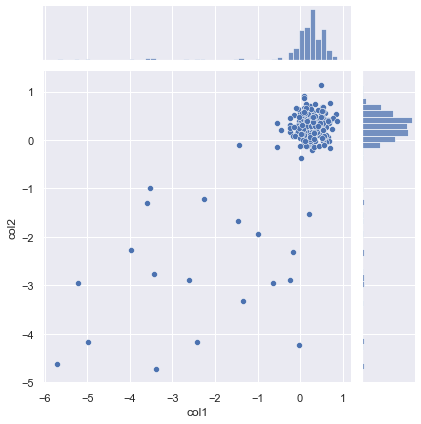

In [22]:
sns.jointplot(data=data, x="col1", y="col2")

In [23]:
data.mean().values
data.cov().values


array([ 3.99680289e-16, -1.20792265e-15])

array([[1.        , 0.76180002],
       [0.76180002, 1.        ]])

Text(0.5, 1.0, 'Multivariates pdf')

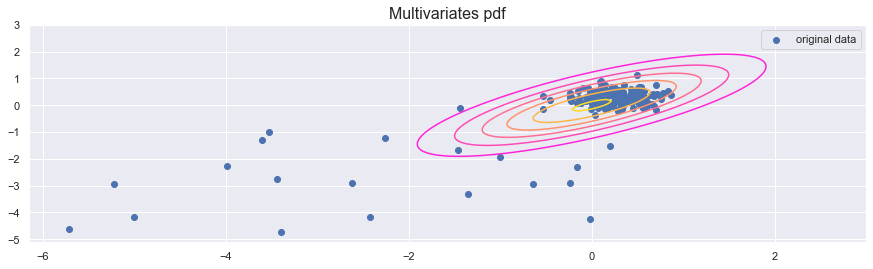

In [24]:
import scipy.stats as stats
fig = plt.figure(figsize=(15,4))
rv = stats.multivariate_normal(data.mean().values, data.cov().values)
xx1 = np.linspace(-3, 3, 100); xx2 = np.linspace(-3, 3, 100)
xx1, xx2 = np.meshgrid(xx1, xx2)
plt.contour(xx1, xx2, rv.pdf(np.dstack([xx1, xx2])), cmap='spring')
plt.scatter(data['col1'], data['col2'], label='original data')
plt.legend()
plt.title("Multivariates pdf", fontsize='16')

EllipticEnvelope(contamination=0.075, random_state=0)

<Figure size 1080x288 with 0 Axes>

Text(0.5, 0, 'col1')

Text(0, 0.5, 'col2')

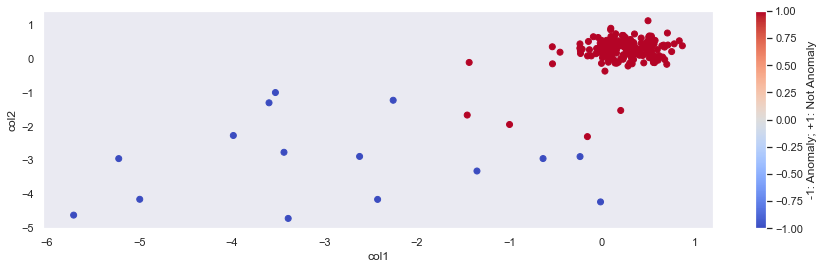

In [25]:
from sklearn.covariance import EllipticEnvelope
### The outliers added above are what we want to detect ####
############# Use Mahalanobis distance method to detect them ####
# Define the Elliptic Envelope
el = EllipticEnvelope(store_precision=True, assume_centered=False, support_fraction=None, 
                      contamination=0.075, random_state=0)
# Fit the data - this is where FastMCD is used by sklearn
el.fit(data)
# Create column that shows anomaly status
data['Anomaly or Not'] = el.predict(data)
# Create scatterplot and color the anomalies differently
plt.figure(figsize = (15, 4))
ax = plt.scatter(data['col1'], data['col2'], c = data['Anomaly or Not'], cmap = 'coolwarm')
plt.xlabel('col1'); plt.ylabel('col2')
plt.colorbar(label = '-1: Anomaly; +1: Not Anomaly')
plt.grid()

## 모든 변수에서 주성분 2개를 추출하여 시각화

총변동량 설명비율 (%) : [72.51  9.3   8.78  5.85  3.56]


Text(0.5, 0, '주성분 개 수')

Text(0, 0.5, '총변동량 누적 설명 비율')

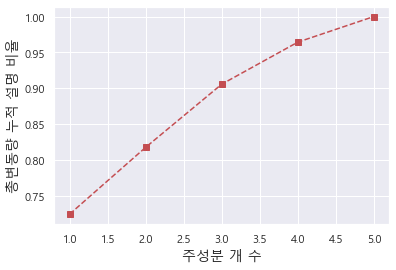

In [26]:
from sklearn.decomposition import PCA
pca = PCA().fit(df)
plt.rcParams['font.family']='Malgun Gothic'
print('총변동량 설명비율 (%) :', np.round(pca.explained_variance_ratio_*100, 2))
plt.plot(np.arange(1, df.shape[1]+1), np.cumsum(pca.explained_variance_ratio_), 'rs--')
plt.xlabel('주성분 개 수', fontsize='14'); plt.ylabel('총변동량 누적 설명 비율', fontsize='14')

In [27]:
pca = PCA(n_components=2).fit(df)
X_pca = pca.transform(df)
print('총변동량 설명비율 (%) :', np.round(pca.explained_variance_ratio_*100, 2))

총변동량 설명비율 (%) : [72.51  9.3 ]


In [28]:
X_pca = pd.DataFrame(X_pca, columns= ['pca_1', 'pca_2'])

EllipticEnvelope(contamination=0.075, random_state=0)

<Figure size 1080x288 with 0 Axes>

Text(0.5, 0, 'pca_1')

Text(0, 0.5, 'pca_2')

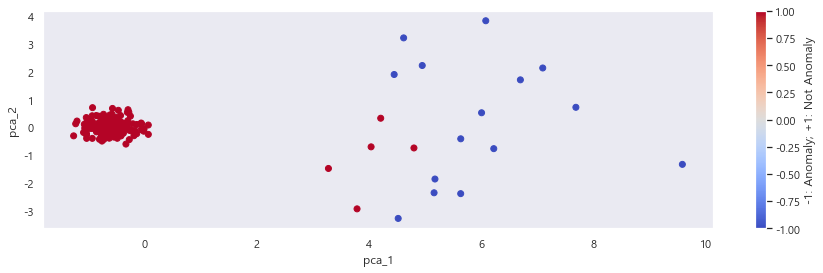

In [29]:
plt.rcParams['axes.unicode_minus'] = False

el.fit(X_pca)
# Create column that shows anomaly status
X_pca['Anomaly or Not'] = el.predict(X_pca)
# Create scatterplot and color the anomalies differently
plt.figure(figsize = (15, 4))
ax = plt.scatter(X_pca['pca_1'], X_pca['pca_2'], c = X_pca['Anomaly or Not'], cmap = 'coolwarm')
plt.xlabel('pca_1'); plt.ylabel('pca_2')
plt.colorbar(label = '-1: Anomaly; +1: Not Anomaly')
plt.grid()

### 3.3. Isolation Forest 알고리즘 (여러가지 이상치 탐색 알고리즘의 하나)
- https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.IsolationForest.html
<img src='https://editor.analyticsvidhya.com/uploads/32290IF.png'>

In [30]:
df = pd.DataFrame(X_train, columns = ['col1', 'col2', 'col3', 'col4', 'col5'])
df

,col1,col2,col3,col4,col5
0,0.300548,-0.124778,0.191554,0.192675,0.213087
1,0.104091,0.285491,0.131715,-0.035583,0.452032
2,0.513657,0.680815,0.289600,0.180795,0.098817
3,-0.145582,0.516857,-0.055095,-0.004925,0.182728
4,0.677891,0.348741,-0.031953,0.107419,0.387964
...,...,...,...,...,...
195,-3.436812,-2.766888,-2.182916,-2.958632,-0.100108
196,-0.236113,-2.894276,-4.954336,-2.909056,0.193368
197,-3.984221,-2.269391,-5.140513,-2.499955,-0.030997
198,-3.391254,-4.726257,-2.312871,-0.880416,-3.410348


In [31]:
from sklearn.ensemble import IsolationForest
isolation_forest = IsolationForest(n_estimators=100)
isolation_forest.fit(df['col1'].values.reshape(-1, 1))

IsolationForest()

In [32]:
anomaly_score = isolation_forest.decision_function(df['col1'].values.reshape(-1, 1))
outlier = isolation_forest.predict(df['col1'].values.reshape(-1, 1))

In [33]:
data = pd.DataFrame(np.c_[anomaly_score, outlier], columns = ['anomaly_score', 'outlier'])
data['original'] = df['col1'].values
data

,anomaly_score,outlier,original
0,0.103644,1.0,0.300548
1,0.119190,1.0,0.104091
2,0.097525,1.0,0.513657
3,0.017444,1.0,-0.145582
4,0.010117,1.0,0.677891
...,...,...,...
195,-0.139638,-1.0,-3.436812
196,0.024167,1.0,-0.236113
197,-0.228304,-1.0,-3.984221
198,-0.152033,-1.0,-3.391254


### Anomaly score로 이상치 확인

<AxesSubplot:>

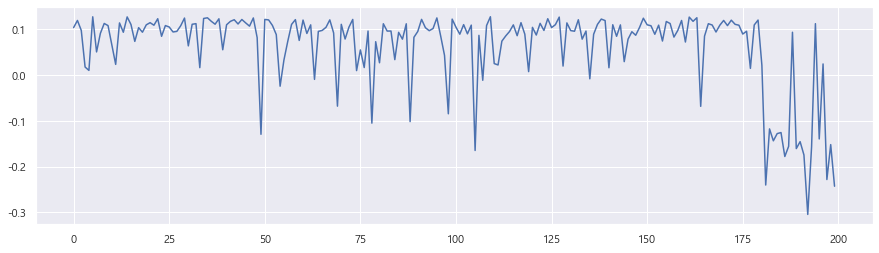

In [34]:
data['anomaly_score'].plot(figsize=(15, 4))

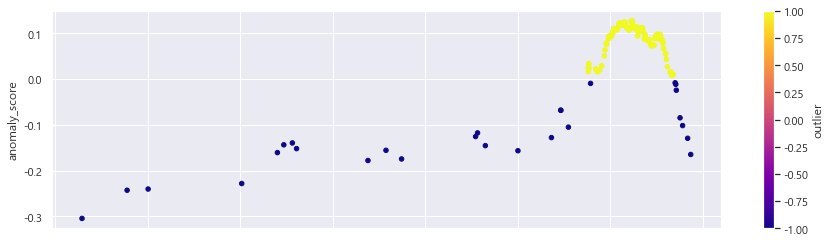

In [35]:
ax2 = data.plot.scatter(x='original', y='anomaly_score',
                        c='outlier',
                        colormap='plasma',
                        figsize=(15,4))

<AxesSubplot:>

<AxesSubplot:>

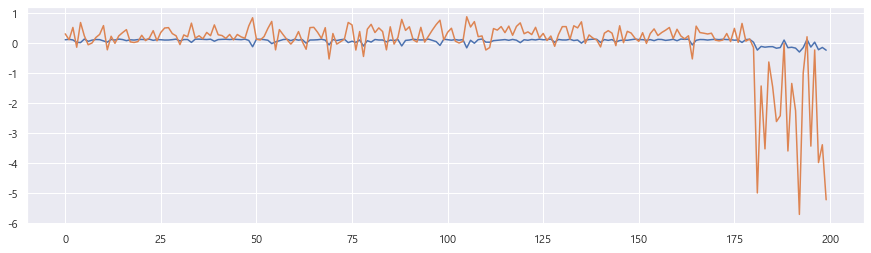

In [36]:
data['anomaly_score'].plot(figsize=(15, 4))
data['original'].plot(figsize=(15,4))

### 자료 시각화
- 원래데이터의 최소값과 최대값을 instance만큼 보간법으로 xx를 생성하여 예측

In [37]:
xx = np.linspace(df['col1'].min(), df['col1'].max(), len(df)).reshape(-1,1)
anomaly_score = isolation_forest.decision_function(xx)
outlier = isolation_forest.predict(xx)
outlier

array([-1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1,
       -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1,
       -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1,
       -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1,
       -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1,
       -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1,
       -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1,
       -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1,
       -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1,
       -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1,  1,  1,  1,  1,  1,
        1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,
        1,  1,  1,  1,  1,  1,  1, -1, -1, -1, -1, -1, -1])

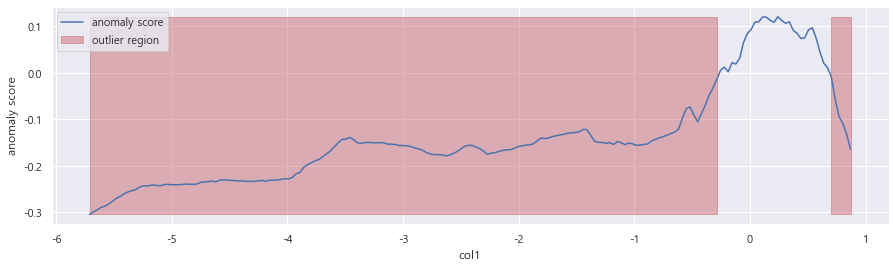

In [38]:
plt.figure(figsize=(15,4))
plt.plot(xx, anomaly_score, label='anomaly score')
plt.fill_between(xx.T[0], np.min(anomaly_score), np.max(anomaly_score), 
                 where=outlier==-1, color='r', 
                 alpha=.4, label='outlier region')
plt.legend()
plt.ylabel('anomaly score')
plt.xlabel('col1')
plt.show();

### 변수별로 이상치 구역 살펴보기
- 음수이면 이상치로 판정하고 이상치(anomaly score)의 절대값이 클수록 이상치일 가능성이 높다.

In [39]:
outlier.shape

(200,)

In [40]:
isolation_forest = IsolationForest(n_estimators=100)

def Iforest(col):
    isolation_forest.fit(df[col].values.reshape(-1, 1))
    xx = np.linspace(df[col].min(), df[col].max(), len(df)).reshape(-1,1)
    anomaly_score = isolation_forest.decision_function(xx)
    outlier = isolation_forest.predict(xx)
    plt.figure(figsize=(10,4))
    plt.plot(xx, anomaly_score, label='anomaly score')
    plt.fill_between(xx.T[0], np.min(anomaly_score), np.max(anomaly_score), 
                     where=outlier==-1, color='r', 
                     alpha=.4, label='outlier region')
    plt.legend()
    plt.ylabel('anomaly score')
    plt.xlabel(col)
    plt.show();

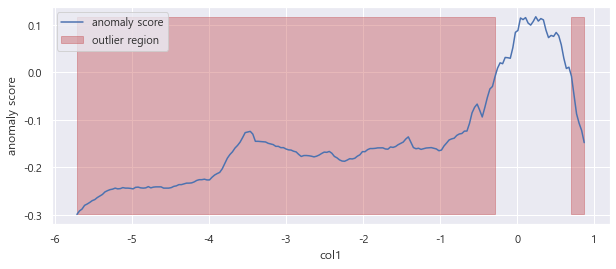

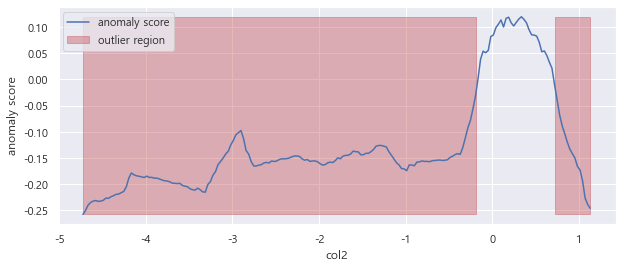

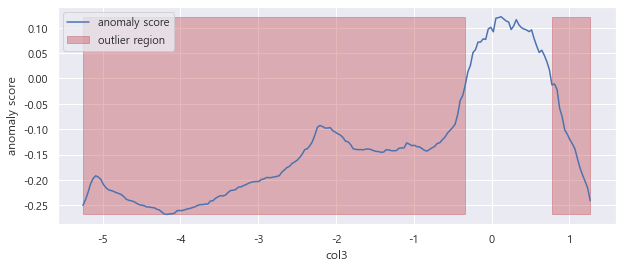

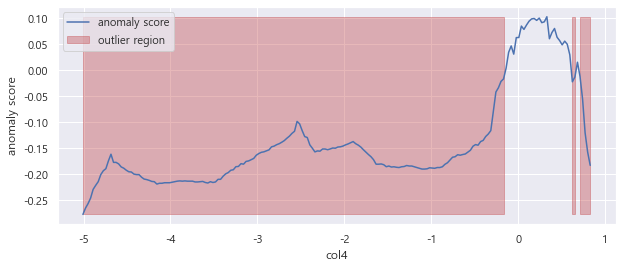

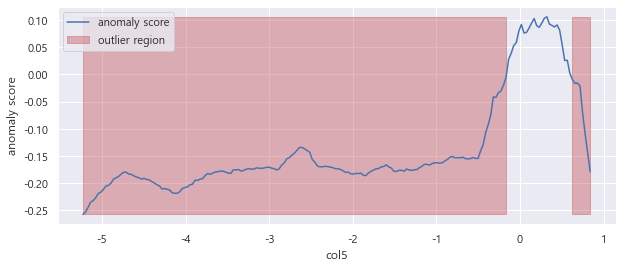

In [41]:
for col in df.columns:
    Iforest(col)

## For further study
- https://towardsdatascience.com/anomaly-detection-for-dummies-15f148e559c1

# End

### 미술시간 - plt.fill_between
- https://wikidocs.net/92086 (두 그래프 영역채우기)

Text(0.5, 0, 'X-Axis')

Text(0, 0.5, 'Y-Axis')

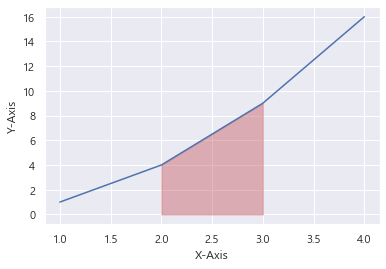

In [42]:
x = np.arange(1,5); y = x**2
plt.plot(x, y)
plt.xlabel('X-Axis'); plt.ylabel('Y-Axis')
plt.fill_between(x[1:3], y[1:3], color='r', 
                 alpha=.4, label='outlier region'
                )

Text(0.5, 0, 'X-Axis')

Text(0, 0.5, 'Y-Axis')

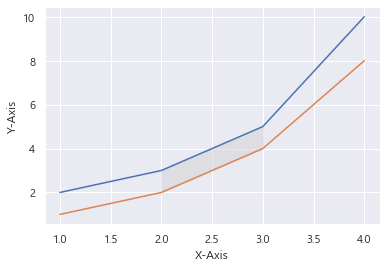

In [43]:
x = [1, 2, 3, 4]
y1 = [2, 3, 5, 10]
y2 = [1, 2, 4, 8]

plt.plot(x, y1)
plt.plot(x, y2)
plt.xlabel('X-Axis')
plt.ylabel('Y-Axis')
plt.fill_between(x[1:3], y1[1:3], y2[1:3], color='lightgray', alpha=0.5)

plt.show()

Text(0.5, 0, 'X-Axis')

Text(0, 0.5, 'Y-Axis')

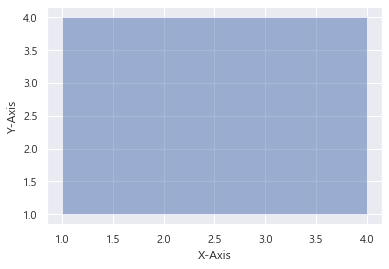

In [44]:
plt.xlabel('X-Axis'); plt.ylabel('Y-Axis')
plt.fill_between(x, np.min(x), np.max(x),alpha=0.5)